In [17]:
!pip install agentpy

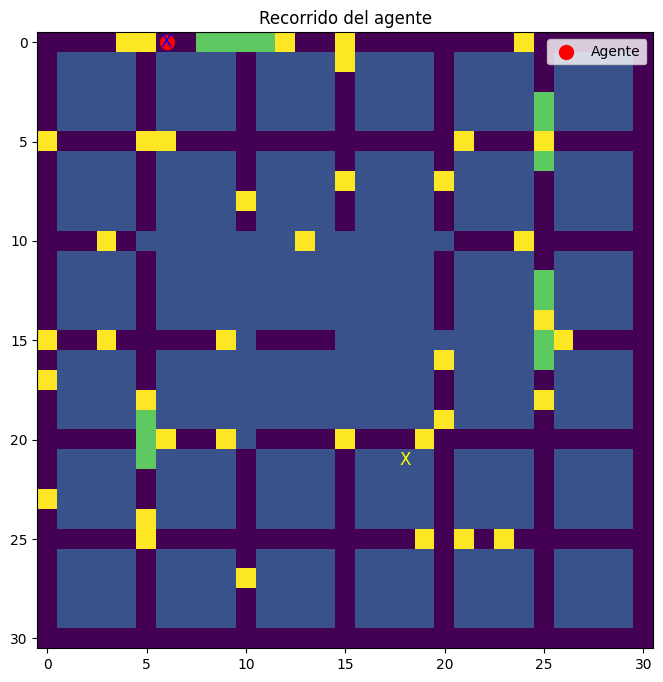

In [4]:
import agentpy as ap
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import IPython
from collections import deque

# Cargar mapa
data = np.load("streets-e.npy", allow_pickle=True)

# Validar que el archivo se haya cargado
if data is None or data.size == 0:
    raise ValueError("El archivo streets-e.npy no se cargo correctamente o esta vacio.")

# Definir condiciones de las calles y sus tiempos de transito
street_conditions = {
    1: 1,    # Calle en buen estado (Verde)
    2: 2,    # Camino de tierra (Cafe claro)
    4: 4,    # Grietas y fugas de agua (Azul)
    5: 5,    # Baches (Gris claro)
    -1: None,  # Cierre de calles (Negro)
    -10: None  # Edificios (Rojo)
}

# Mapa de colores para la visualizacion
color_map = {
    1: "green",
    2: "#D2B48C",
    4: "blue",
    5: "#D3D3D3",
    -1: "black",
    -10: "#FF0000"
}

#Coordenadas de inicio y final
start_position = (0, 6)    # Hose
goal_position = (21, 18)   # Work

def make_transitable(map_data, start, goal):
    mod_map = map_data.copy()
    queue = deque([start])
    visited = set([start])

    while queue:
        x, y = queue.popleft()
        if (x, y) == goal:
            break
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < mod_map.shape[0] and 0 <= ny < mod_map.shape[1]:
                if mod_map[nx, ny] in [-1, -10]:
                    mod_map[nx, ny] = 1
                if (nx, ny) not in visited:
                    visited.add((nx, ny))
                    queue.append((nx, ny))
    return mod_map

# Aplicar modificacion al mapa para que tenga un camino transitable
data = make_transitable(data, start_position, goal_position)

# Definir la clase de la ciudad que encuentra la mejor ruta con BFS
class City:
    def __init__(self, city_map):
        self.city_map = city_map

    def get_movement(self, direction):
        return {'up': (-1, 0), 'down': (1, 0), 'left': (0, -1), 'right': (0, 1)}[direction]

    def is_valid_move(self, position):
        return (0 <= position[0] < self.city_map.shape[0] and
                0 <= position[1] < self.city_map.shape[1] and
                self.city_map[position] not in (-1, -10))  # No se puede mover si hay edificios o calles cerradas

    def bfs(self, start, goal):
        queue = deque([(start, [start])])
        visited = {start}
        while queue:
            (vertex, path) = queue.popleft()
            if vertex == goal:
                return path  # Si llegamos al destino, regresamos la ruta
            for direction in ['up', 'down', 'left', 'right']:
                movement = self.get_movement(direction)
                next_vertex = (vertex[0] + movement[0], vertex[1] + movement[1])
                if self.is_valid_move(next_vertex) and next_vertex not in visited:
                    visited.add(next_vertex)
                    queue.append((next_vertex, path + [next_vertex]))
        return None  # Si no encuentra ruta, regresa None

# Crear la ciudad y encontrar la mejor ruta
city = City(data)
best_route = city.bfs(start_position, goal_position)

# Visualizacion del recorrido
fig, ax = plt.subplots(figsize=(8, 8))

def animate(i):
    ax.clear()
    ax.imshow(data, cmap="viridis", interpolation="nearest")  # Mostrar mapa

    if best_route:
        x, y = best_route[i % len(best_route)]
        ax.scatter(y, x, color='red', s=100, label='Agente')  # Agente
    else:
        ax.text(data.shape[1] // 2, data.shape[0] // 2, "No path found", color="red", fontsize=16, ha='center', va='center')

    # Marcar inicio y destino con X
    ax.text(start_position[1], start_position[0], 'X', color='blue', fontsize=12, ha='center', va='center')
    ax.text(goal_position[1], goal_position[0], 'X', color='yellow', fontsize=12, ha='center', va='center')
    ax.set_title("Recorrido del agente")
    ax.legend()

ani = animation.FuncAnimation(fig, animate, frames=len(best_route) if best_route else 1, interval=500)

IPython.display.HTML(ani.to_jshtml())

1. El entorno es una ciudad representada como una matriz (numpy array), donde cada celda representa una calle con diferentes condiciones o una zona intransitable (cierres o edificios). Las calles tienen diferentes valores de costo de transito segun su estado:

*    Calles en buen estado (1): Transitables con el menor costo de movimiento.
*   Caminos de tierra (2): Transitables pero con mayor costo.


*  Calles con grietas y fugas (4): Dificultan el transito, aumentando el costo.
*   Baches (5): Requieren mas tiempo para atravesarlas.


*     Cierres de calles (-1) y edificios (-10): No son transitables.


  
  2. Componentes del Agente:
El agente representa un ciudadano que busca la mejor ruta de su casa al trabajo y se modela con los siguientes elementos:

  **Estados:** Cada estado es una posicion (x, y) en la matriz que representa la ciudad.

  **Acciones:** El agente puede moverse en cuatro direcciones: arriba, abajo, izquierda y derecha.
  
 **Meta:** La meta del agente es alcanzar la posicion (21,18), que representa el estacionamiento de su trabajo.
  
  **Utilidad:** La funcion de utilidad es minimizar el tiempo total de transito, es decir, encontrar el camino con el menor costo acumulado de calles transitadas.
